In [9]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm import tqdm
import torchvision.transforms as transforms

In [10]:
# Defining the transformations on the data
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

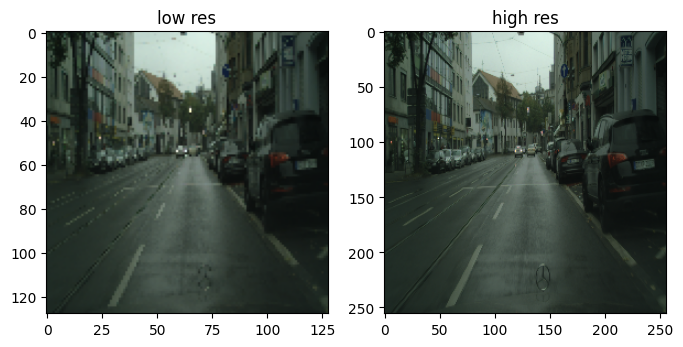

In [11]:
def find_all_files(directory):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files
# Custom dataset for images
class ImageDataset(Dataset):
    def __init__(self, root_dir, low_res_subdir, high_res_subdir, augment=False):
        super(ImageDataset, self).__init__()
        self.low_res_dir = os.path.join(root_dir, low_res_subdir)
        self.high_res_dir = os.path.join(root_dir, high_res_subdir)
        self.low_res_files = find_all_files(self.low_res_dir)
        self.high_res_files = find_all_files(self.high_res_dir)
        self.data = list(zip(self.low_res_files, self.high_res_files))
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]

        # Open the low and high resolution images
        low_res = np.array(Image.open(img_low_file))
        high_res = np.array(Image.open(img_high_file))

        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]

        # Applying augmentations to the input dataset
        if self.augment:
            if random.random() > 0.5:
                low_res = np.fliplr(low_res).copy()
                high_res = np.fliplr(high_res).copy()
            if random.random() > 0.5:
                low_res = np.flipud(low_res).copy()
                high_res = np.flipud(high_res).copy()
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                low_res = np.rot90(low_res, k=angle // 90).copy()
                high_res = np.rot90(high_res, k=angle // 90).copy()

        # Applying the transformation to the images
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)

        return low_res, high_res

# Displaying an image from the dataset
def show_image():
    dataset = ImageDataset(root_dir="/kaggle/input", 
                           low_res_subdir="reduced-cityscapes/resized_low_res/train", 
                           high_res_subdir="reduced-cityscapes/resized_high_res/train")
    loader = DataLoader(dataset, batch_size=128, num_workers=4)
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")
        if idx == 0:
            break
    plt.show()           
show_image()

# Define hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
epochs = 15
batch_size = 8
num_workers = 2
img_channels = 3

# VGG perceptual loss
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(weights="IMAGENET1K_V1").features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

In [12]:
# Architecture of SRGAN
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_activation=True, use_BatchNorm=True, **kwargs):
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.cnn(x)
        x = self.bn(x)
        if self.use_activation:
            x = self.ac(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.b2 = ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1, use_activation=False)

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [13]:
# Generator of the GAN
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=8):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

# Discriminator of the GAN
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

In [14]:
import os
from torchvision.utils import save_image

def save_generated_images(gen, loader, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    gen.eval()
    with torch.no_grad():
        for idx, (low_res, _) in enumerate(loader):
            low_res = low_res.to(device)
            fake = gen(low_res)
            for i in range(fake.size(0)):
                file_path = loader.dataset.low_res_files[idx * loader.batch_size + i]
                city = file_path.split('/')[-2]
                output_city_dir = os.path.join(output_dir, city)
                os.makedirs(output_city_dir, exist_ok=True)
                filename = file_path.split('/')[-1]
                save_image(fake[i], os.path.join(output_city_dir, filename))
    gen.train()

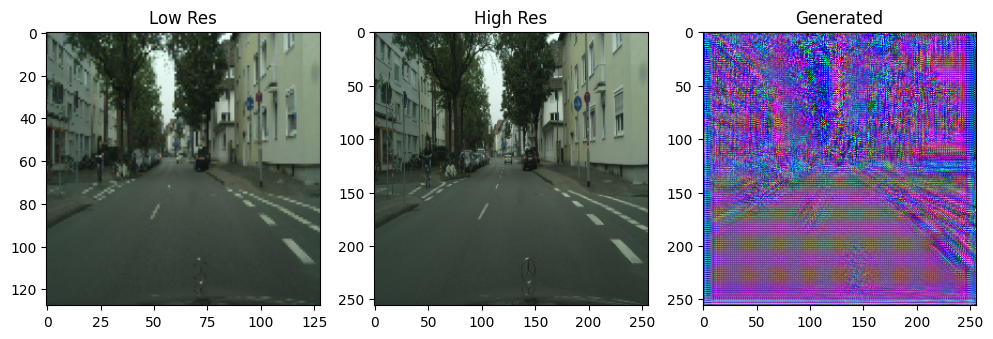

Epoch 1/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.892, gen_loss=0.0106]


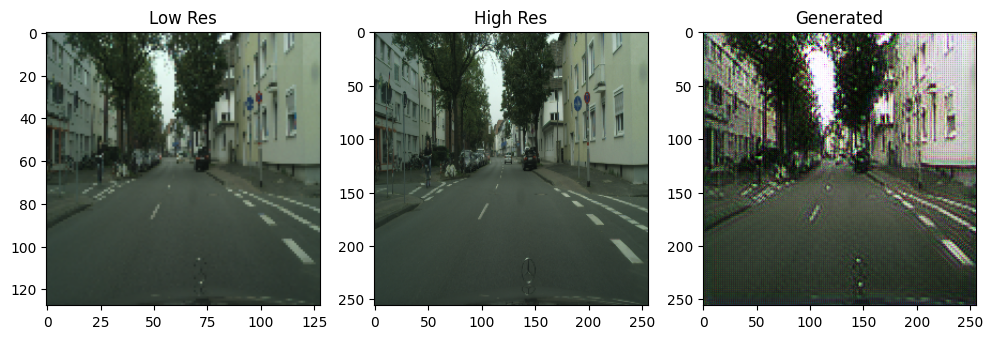

Epoch 2/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.694, gen_loss=0.00634]


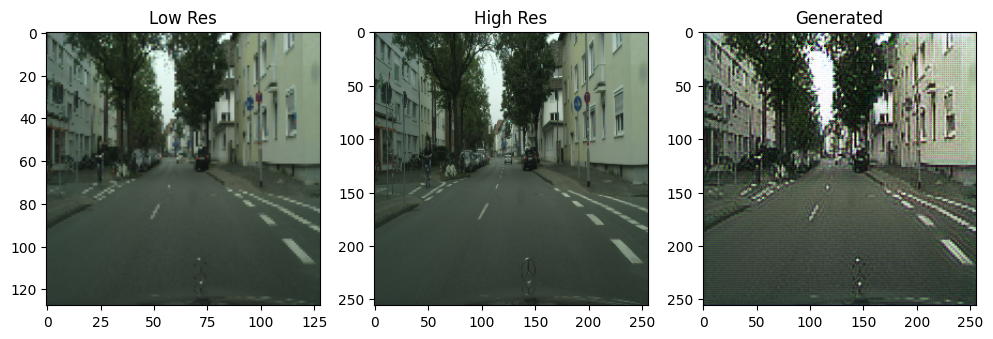

Epoch 3/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.667, gen_loss=0.00558]


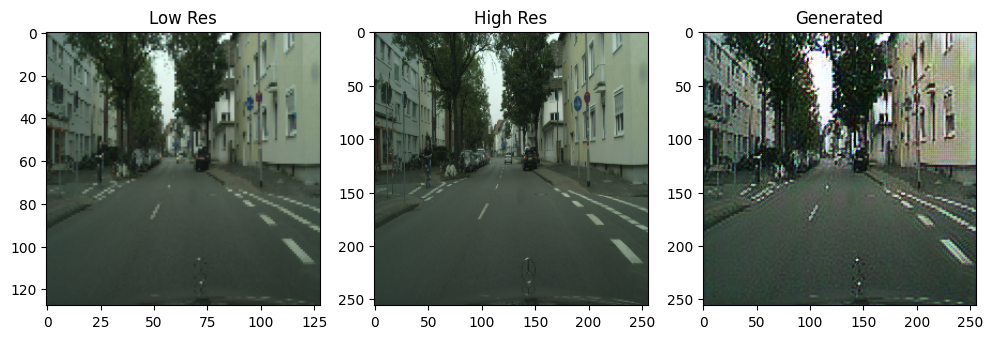

Epoch 4/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.646, gen_loss=0.00527]


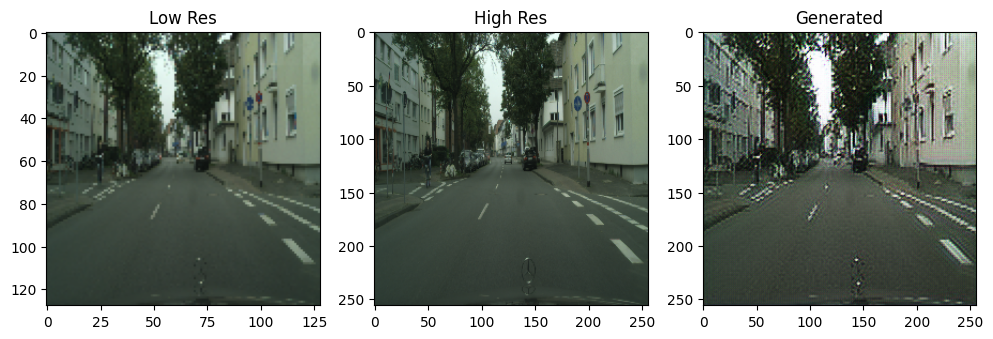

Epoch 5/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.625, gen_loss=0.00531]


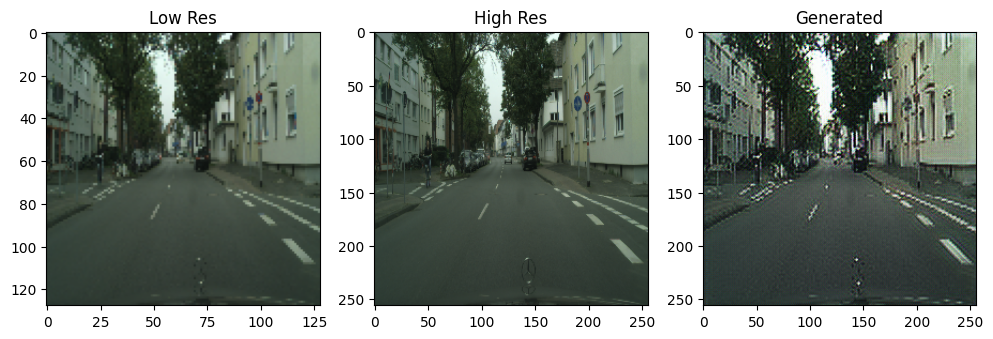

Epoch 6/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.666, gen_loss=0.00506]


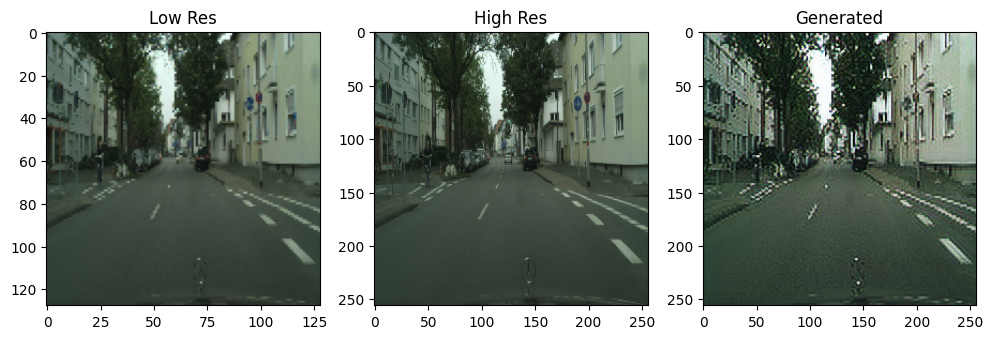

Epoch 7/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.603, gen_loss=0.00507]


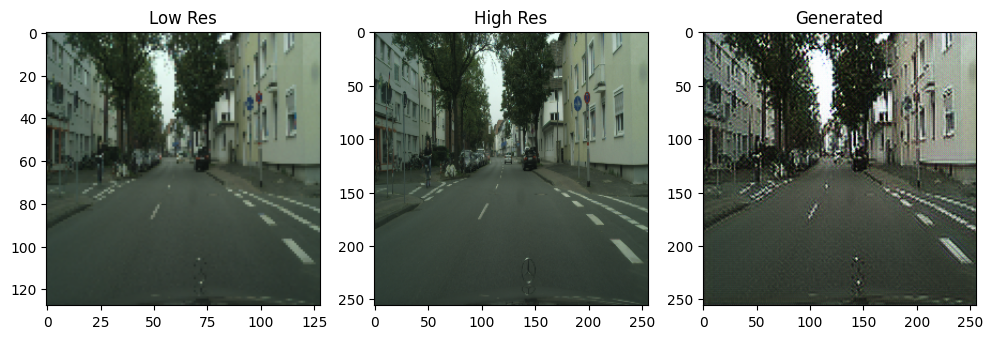

Epoch 8/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.639, gen_loss=0.00501]


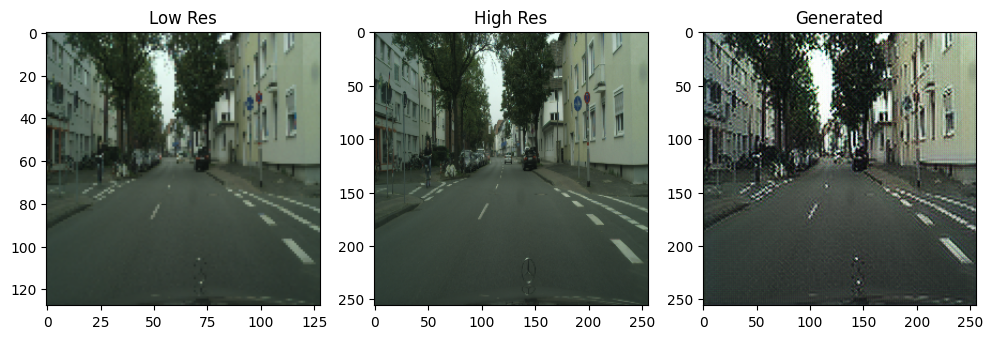

Epoch 9/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.597, gen_loss=0.00502]


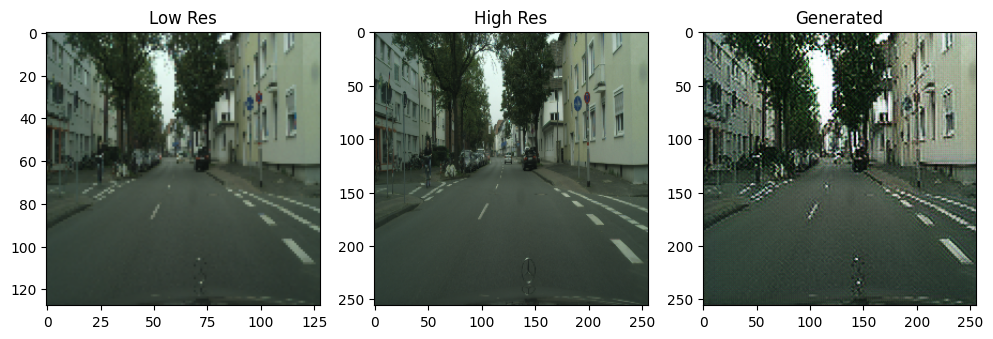

Epoch 10/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.572, gen_loss=0.00513]


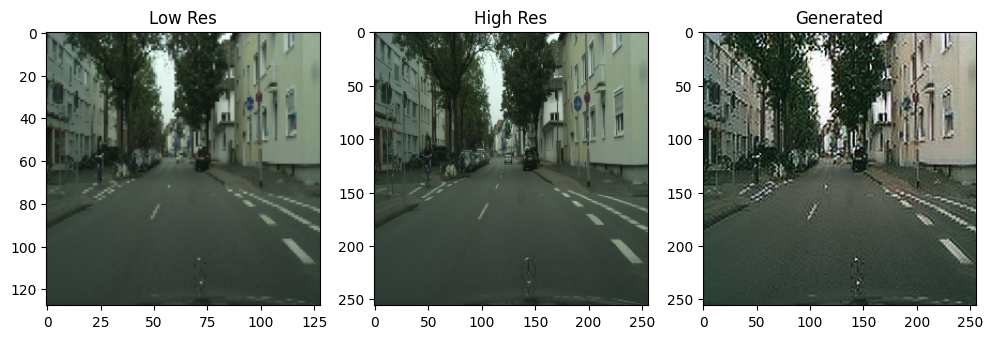

Epoch 11/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.58, gen_loss=0.00502] 


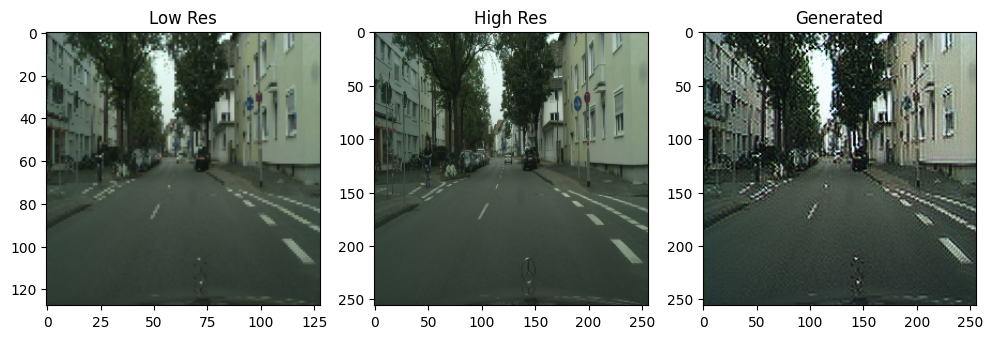

Epoch 12/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.565, gen_loss=0.00505]


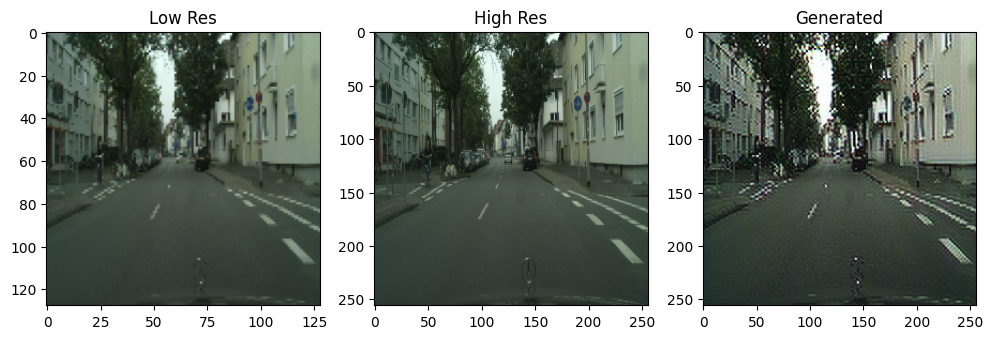

Epoch 13/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.573, gen_loss=0.00484]


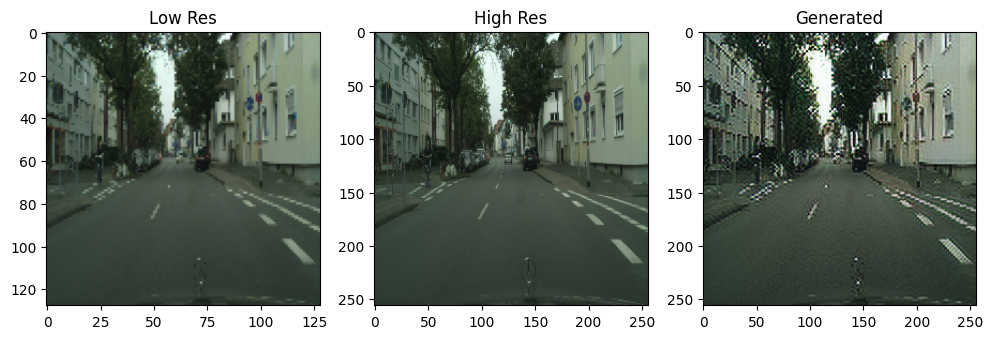

Epoch 14/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.566, gen_loss=0.00494]


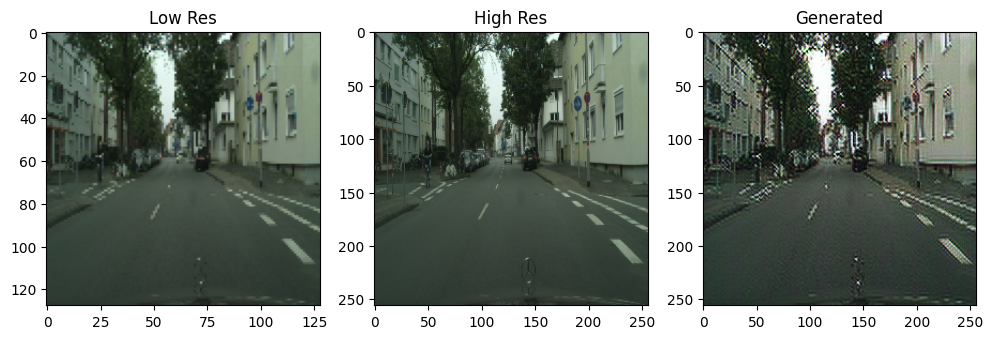

Epoch 15/15


100%|██████████| 124/124 [01:43<00:00,  1.19it/s, disc_loss=0.585, gen_loss=0.00486]


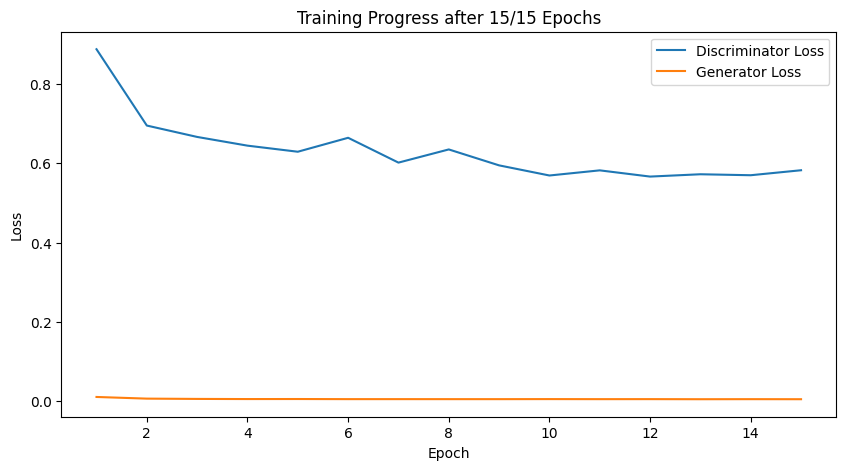

In [15]:
def plot_images(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input", 
                                low_res_subdir="/kaggle/input/reduced-cityscapes/resized_low_res/val", 
                                high_res_subdir="/kaggle/input/reduced-cityscapes/resized_high_res/val")
    loader = DataLoader(dataset_test, batch_size=1, num_workers=2)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    for low_res, high_res in loader:
        low_res = low_res.to(device)
        with torch.no_grad():
            fake = gen(low_res)
        axs[0].imshow(low_res[0].permute(1, 2, 0).cpu().numpy())
        axs[0].set_title("Low Res")
        axs[1].imshow(high_res[0].permute(1, 2, 0).cpu().numpy())
        axs[1].set_title("High Res")
        axs[2].imshow(fake[0].permute(1, 2, 0).cpu().numpy())
        axs[2].set_title("Generated")
        break
    plt.show()
    
# Define generator and discriminator, optimizers, and loss functions
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.7, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.7, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

# Data loaders for training and validation
train = ImageDataset(root_dir="/kaggle/input",
                     low_res_subdir="reduced-cityscapes/resized_high_res/train",
                     high_res_subdir="reduced-cityscapes/resized_high_res/train")
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

val = ImageDataset(root_dir="/kaggle/input",
                   low_res_subdir="reduced-cityscapes/resized_low_res/val",
                   high_res_subdir="reduced-cityscapes/resized_high_res/val")
val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

import torch.nn.init as init

# Define weight initialization function
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            init.kaiming_normal_(m.weight)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

# Apply weight initialization
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
initialize_weights(gen)
initialize_weights(disc)

# Adjust learning rates and betas
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.5, 0.999))

# Training function with gradient penalty
# Training function with image saving
def train_model(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, lambda_gp=10):
    loop = tqdm(loader, leave=True)
    disc_loss_accum = 0
    gen_loss_accum = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)

        # Train Discriminator
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real) * 0.9)  # Label smoothing
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        disc_loss = (disc_loss_real + disc_loss_fake) / 2

        # Gradient penalty
        alpha = torch.rand(high_res.size(0), 1, 1, 1).to(device)
        interpolated = alpha * high_res + (1 - alpha) * fake.detach()
        interpolated.requires_grad_(True)
        interpolated_output = disc(interpolated)
        gradients = torch.autograd.grad(
            outputs=interpolated_output,
            inputs=interpolated,
            grad_outputs=torch.ones(interpolated_output.size()).to(device),
            create_graph=True,
            retain_graph=True
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        disc_loss += gradient_penalty

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        perceptual_loss = 0.006 * vgg_loss(fake, high_res)
        gen_loss = perceptual_loss + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        disc_loss_accum += disc_loss.item()
        gen_loss_accum += gen_loss.item()

        if idx % 10 == 0:
            loop.set_postfix(
                disc_loss=disc_loss_accum / (idx + 1),
                gen_loss=gen_loss_accum / (idx + 1),
            )

    return gen_loss_accum / len(loop), disc_loss_accum / len(loop)

def save_final_generated_images(gen, loader, output_dir):
    gen.eval()
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        for idx, (low_res, _) in enumerate(loader):
            low_res = low_res.to(device)
            fake = gen(low_res)
            for i in range(fake.size(0)):
                file_path = loader.dataset.low_res_files[idx * loader.batch_size + i]
                city = file_path.split('/')[-2]
                output_city_dir = os.path.join(output_dir, city)
                os.makedirs(output_city_dir, exist_ok=True)
                filename = file_path.split('/')[-1]
                save_image(fake[i], os.path.join(output_city_dir, filename))
    gen.train()


def train_progress(epoch, epochs, d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 1), d_losses, label='Discriminator Loss')
    plt.plot(range(1, epoch + 1), g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Training Progress after {epoch}/{epochs} Epochs")
    plt.show()

# Training loop
d_losses = []
g_losses = []
for epoch in range(epochs):
    plot_images(gen)
    print(f"Epoch {epoch + 1}/{epochs}")
    gen_loss, disc_loss = train_model(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)

train_progress(epochs, epochs, d_losses, g_losses)

save_final_generated_images(gen, train_loader, "/kaggle/working/generated_images/train_final")
save_final_generated_images(gen, val_loader, "/kaggle/working/generated_images/val_final")

# Save models
torch.save(gen.state_dict(), "generator_model.pth")
torch.save(disc.state_dict(), "discriminator_model.pth")

In [16]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_metrics(gen, loader, win_size=11):
    psnr_total = 0
    ssim_total = 0
    num_images = 0
    data_range = 1.0

    for low_res, high_res in loader:
        low_res = low_res.to(device)
        high_res = high_res.to(device)

        with torch.no_grad():
            fake = gen(low_res)

        fake_np = fake.permute(0, 2, 3, 1).cpu().numpy()
        high_res_np = high_res.permute(0, 2, 3, 1).cpu().numpy()

        for i in range(fake_np.shape[0]):
            psnr_total += peak_signal_noise_ratio(high_res_np[i], fake_np[i])
            ssim_total += structural_similarity(high_res_np[i], fake_np[i], multichannel=True, win_size=win_size, data_range=data_range)
            num_images += 1

    psnr_avg = psnr_total / num_images
    ssim_avg = ssim_total / num_images

    print(f"Average PSNR: {psnr_avg}")
    print(f"Average SSIM: {ssim_avg}")

# Evaluate metrics on the validation set
evaluate_metrics(gen, val_loader, win_size=3)

Average PSNR: 20.13144169888745
Average SSIM: 0.6105433073293027
